In [1]:
# pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git
from amarinml import *

In [2]:
import numpy as np
import pandas as pd
import copy
import os
import joblib
import ctypes
import gc
from probatus.feature_elimination import ShapRFECV
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from catboost import CatBoostRegressor, Pool
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
import shap
from probatus.utils import Scorer
from sklearn.metrics import mean_squared_error, make_scorer, mean_pinball_loss, mean_absolute_error, classification_report, confusion_matrix, median_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

os.environ.pop("OPENBLAS_NUM_THREADS", None)  # None = ignore if not present
SEED = 23
pd.set_option('display.max_columns', None)

In [3]:
# tell Windows to stay awake
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000 | 0x00000001)

-2147483648

In [ ]:
class SinglePointTimeSeriesSplitByTicker:
    """
    Forward-expanding, single-point test per split (per ticker).
    For each ticker with N rows and n_splits = k, the test positions are:
    N-k, N-k+1, ..., N-1  (0-based within that ticker).
    """

    def __init__(self, n_splits=3):
        if n_splits < 1:
            raise ValueError(f"n_splits must be >= 1, got {n_splits}")
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError(
                "X must be a pandas DataFrame with 'Ticker' column")
        if 'Ticker' not in X.columns:
            raise ValueError("DataFrame must have a 'Ticker' column")

        # IMPORTANT: X must be sorted by time within each ticker BEFORE calling split.

        # Precompute positional indices (0..len(X)-1) for each ticker
        tickers = X['Ticker'].to_numpy()
        unique_tickers = pd.unique(tickers)
        ticker_to_pos = {t: np.where(tickers == t)[0] for t in unique_tickers}

        for i in range(self.n_splits):
            train_idx, test_idx = [], []

            for t, pos in ticker_to_pos.items():
                n = len(pos)
                # Need at least n_splits + 1 rows for this ticker
                if n <= self.n_splits:
                    continue

                # forward-expanding single test index (position within this ticker)
                test_pos_in_ticker = n - self.n_splits + i  # e.g., for n=10,k=3: 7,8,9
                test_idx.append(pos[test_pos_in_ticker])
                train_idx.extend(pos[:test_pos_in_ticker])

            if test_idx:
                gc.collect()
                yield np.array(train_idx), np.array(test_idx)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [5]:
# --- Two tickers with different lengths: A=8, B=12 ---
df = pd.DataFrame({
    "Ticker": ["A"]*8 + ["B"]*12,
    "t": list(range(8)) + list(range(12))
})

cv = SinglePointTimeSeriesSplitByTicker(n_splits=2)
for k, (tr, te) in enumerate(cv.split(df), 1):
    print(f"Fold {k}:")
    print("  train idx:", tr.tolist())
    print("  test idx :", te.tolist())

Fold 1:
  train idx: [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
  test idx : [6, 18]
Fold 2:
  train idx: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  test idx : [7, 19]


In [6]:
df = pd.read_csv('D:\GitHub\sp500\sp500_diff.csv', low_memory=False)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by=['Ticker', 'Date'], inplace=True)
df.drop(['Quarter_pct_diff_1', 'Quarter_pct_diff_4',
        'Fiscal year_pct_diff_1', 'Fiscal year_pct_diff_4', 'Fiscal year'], axis=1, inplace=True)
df['Quarter'] = df['Quarter'].astype('int64').astype('category')
print(df.shape)

(17464, 1134)


In [7]:
target = 'Future_Price_pct_diff_1'
df[target] = df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(-1)

predict_df = pd.DataFrame()
for ticker in df['Ticker'].unique():
    ticker_df = df[df['Ticker'] == ticker]
    max_date = ticker_df['Date'].max()
    last_row = ticker_df.loc[ticker_df['Date'] == max_date, :].copy()
    predict_df = pd.concat([predict_df, last_row], ignore_index=True)

df.dropna(inplace=True)
features = df.drop(columns=[target,  'Date'], axis=1).columns.tolist()
cat_features = df.drop(columns=[target, 'Date'], axis=1).select_dtypes(
    include=['object', 'category']).columns.tolist()
num_features = df.drop(columns=[target], axis=1).select_dtypes(
    include=['int64', 'float64']).columns.tolist()
print(
    f'Length of numerical features: {len(num_features)}, categorical: {len(cat_features)} , all features: {len(features)}')

Length of numerical features: 1129, categorical: 4 , all features: 1133


In [8]:
train_df = df.copy()
X_train = train_df[features]
y_train = train_df[target]

In [9]:
# Store average CV scores
medae_scores = []

# Try different delta values for Huber robustness
for delta in [0.5, 1.0, 2.0, 3.0]:
    # Define CatBoost with Huber loss
    model = CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        random_seed=SEED,
        loss_function=f'Huber:delta={delta}',
        eval_metric='RMSE',
        verbose=False,
        thread_count=-1,
        devices='0',
        task_type="GPU",
        data_partition='DocParallel',
        max_ctr_complexity=1,
        cat_features=cat_features,
        boosting_type='Plain',
        bootstrap_type="Bernoulli",
        subsample=0.7,
        border_count=128,
        early_stopping_rounds=50,
        allow_writing_files=False,
        grow_policy="SymmetricTree",
        gpu_ram_part=0.95,
    )

    # Time-series cross-validation
    tscv = SinglePointTimeSeriesSplitByTicker(n_splits=4)

    # Define Median Absolute Error scorer
    medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

    # Cross-validation with MedAE
    scores = cross_val_score(model, X_train, y_train,
                             cv=tscv, scoring=medae_scorer)
    print(f"Delta={delta}, Scores={scores}")
    medae_scores.append(scores.mean())

print("Average Median Absolute Error scores by delta:", medae_scores)

Delta=0.5, Scores=[-0.10910578 -0.09971254 -0.10229055 -0.08028443]
Delta=1.0, Scores=[-0.11238548 -0.09937397 -0.1009102  -0.08093049]
Delta=2.0, Scores=[-0.1054338  -0.09839356 -0.10139244 -0.08191262]
Delta=3.0, Scores=[-0.111005   -0.09839453 -0.09957238 -0.07876747]
Average Median Absolute Error scores by delta: [-0.09784832516579113, -0.0984000366246478, -0.09678310618736491, -0.09693484351473962]


In [10]:
model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=SEED,
    loss_function=f'Huber:delta=2.0',
    eval_metric='RMSE',
    verbose=False,
    thread_count=-1,
    devices='0',
    task_type="GPU",
    data_partition='DocParallel',
    max_ctr_complexity=1,
    cat_features=cat_features,
    boosting_type='Plain',
    bootstrap_type="Bernoulli",
    subsample=0.7,
    border_count=128,
    early_stopping_rounds=50,
    allow_writing_files=False,
    grow_policy="SymmetricTree",
    gpu_ram_part=0.9,
)

In [11]:
model.fit(X_train, y_train, cat_features=cat_features, verbose=False)

# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                                          feature  importance
178                                     MACD_Hist    6.522479
287                                       Quarter    5.251428
956                             RSI_14_pct_diff_4    4.413635
182                         Market Capitalization    3.570135
764                          MinVolume_pct_diff_4    2.921526
761                           MinPrice_pct_diff_1    2.914962
762                           MinPrice_pct_diff_4    2.694110
763                          MinVolume_pct_diff_1    2.259498
432      Cash & Short-Term Investments_pct_diff_4    2.227758
758                       MedianVolume_pct_diff_4    1.769814
588  Foreign Exchange Rate Adjustments_pct_diff_4    1.667411
20                           Book Value Per Share    1.553589
718                   Long-Term Leases_pct_diff_4    1.476143
828                Operating Cash Flow_pct_diff_4    1.465380
191                                      MinPrice    1.386236
688     

In [12]:
# wrap the sklearn scorer in a probatus Scorer (ShapRFECV requires probatus.utils.Scorer)
probatus_medae = Scorer("medae", custom_scorer=medae_scorer)

shap_selector = ShapRFECV(
    model=model,
    cv=tscv,
    step=0.2,
    scoring=probatus_medae,
    n_jobs=1,
    verbose=1,
    random_state=SEED)

shap_selector.fit(X_train, y_train, columns_to_keep=cat_features)

c:\Users\Dell\venv\Lib\site-packages\probatus\utils\arrayfuncs.py:108: UserWarning: The following variables in X contains categorical variables: ['Ticker', 'Quarter', 'GICS Sector', 'GICS Sub-Industry']. Make sure to use a model that handles them automatically or encode them into numerical variables.
  warnings.warn(
c:\Users\Dell\venv\Lib\site-packages\probatus\utils\arrayfuncs.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[object_columns] = X[object_columns].astype("category")


Selected: 468 ['Ticker', 'Additional Paid-In Capital', 'Allowance for Equity Funds for Construction', 'Asset Turnover', 'Asset Writedown', 'Asset Writedown & Restructuring Costs', 'Book Value Per Share', 'Buildings', 'Capital Expenditures', 'Cash & Short-Term Investments', 'Cash Acquisition', 'Cash Acquisitions', 'Cash Income Tax Paid', 'Change in Inventory', 'Change in Trading Asset Securities', 'Change in Unearned Revenue', 'Change in Working Capital', 'ClosePrice', 'Common Stock', 'Comprehensive Income & Other', 'Cost of Revenue', 'CountDividends', 'Currency Exchange Gains', 'Current Income Taxes Payable', 'Current Portion of Leases', 'Current Ratio', 'D&A For EBITDA', 'Debt / EBITDA Ratio', 'Debt / Equity Ratio', 'Debt / FCF Ratio', 'Dividend Per Share', 'EBIT', 'EBT Excluding Unusual Items', 'EPS (Basic)', 'EPS (Diluted)', 'EV/EBIT Ratio', 'EV/EBITDA Ratio', 'EV/FCF Ratio', 'EV/Sales Ratio', 'Earnings From Continuing Operations', 'Enterprise Value', 'FFO Per Share', 'Federal Depos

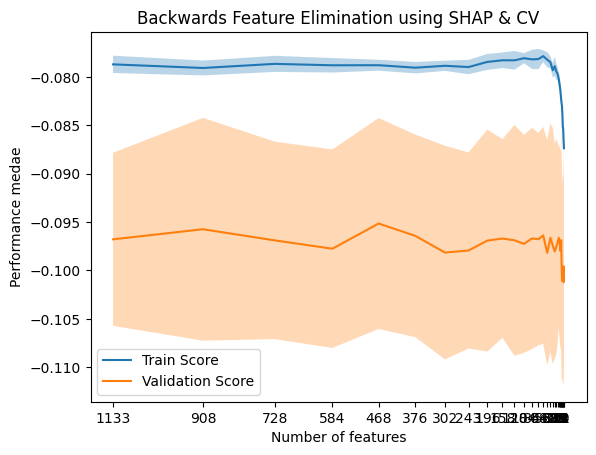

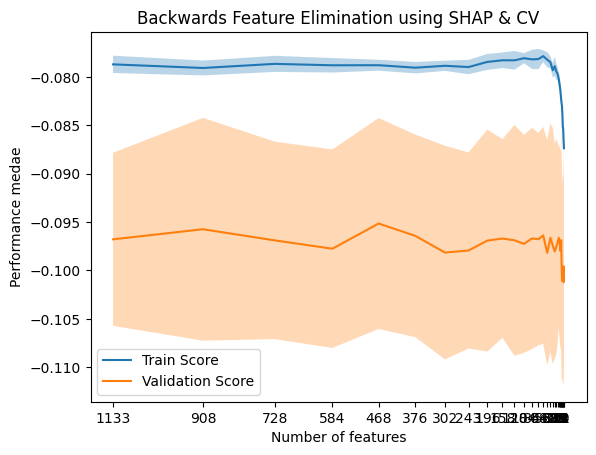

In [13]:
selected = shap_selector.get_reduced_features_set('best')
print("Selected:", len(selected), selected)
shap_selector.plot()

In [14]:
n_iter = 30

# Define search space
param_space = {
    'learning_rate': Real(0.02, 0.2, prior='log-uniform'),
    'depth': Integer(4, 8),
    'l2_leaf_reg': Real(1e-3, 5.0, prior='log-uniform'),
    'iterations': Integer(500, 3000),
    'random_strength': Real(1e-3, 2.0, prior='log-uniform'),
    'min_data_in_leaf': Integer(10, 200),
    'leaf_estimation_iterations': Integer(1, 8),
    'subsample': Real(0.6, 0.9),
}


# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=n_iter,
    cv=tscv,
    scoring=medae_scorer,
    n_jobs=1,
    n_points=1,
    random_state=SEED,
)

# Fit gs
opt.fit(X_train[selected], y_train, cat_features=cat_features,
        callback=callback, verbose=False)

# Retrieve the best model and results
best_model = opt.best_estimator_
results = opt.cv_results_
params = results['params']

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)

joblib.dump(best_model, 'sp500_best_catboost_model.pkl')

100%|██████████| 30/30 [52:40<00:00, 165.98s/it]

Best score: -0.0955201952621552
Best params: OrderedDict([('depth', 5), ('iterations', 500), ('l2_leaf_reg', 0.0129803182305396), ('leaf_estimation_iterations', 2), ('learning_rate', 0.020000000000000004), ('min_data_in_leaf', 10), ('random_strength', 0.0017235179253841638), ('subsample', 0.9)])


['sp500_best_catboost_model.pkl']

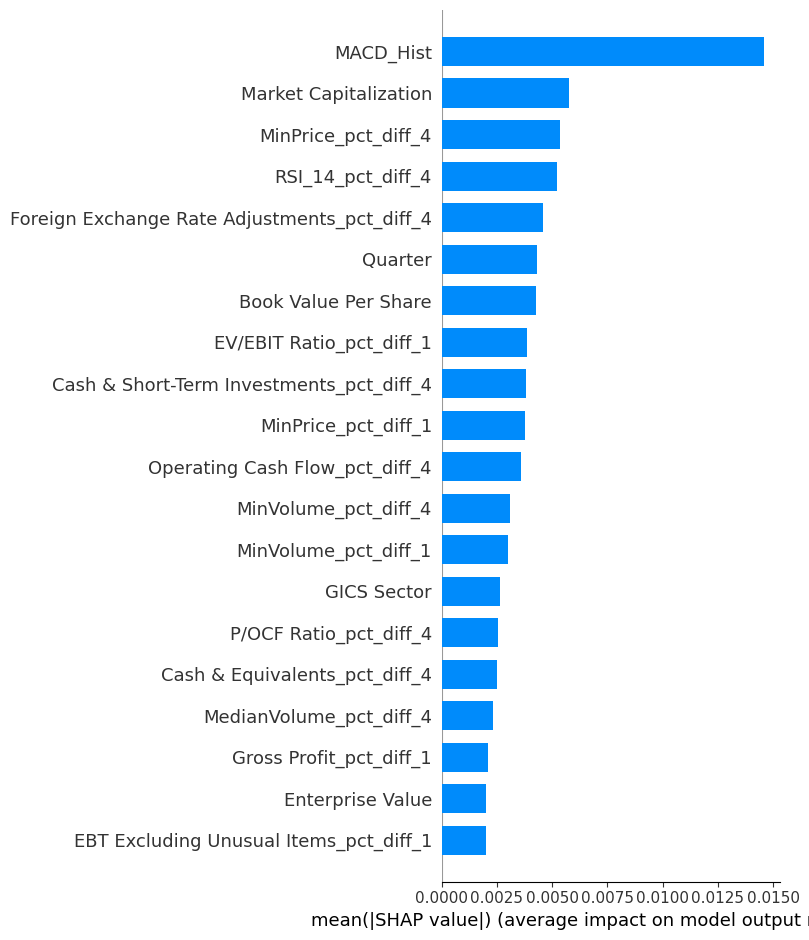

In [15]:
# Use the best model and the selected features
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train[selected])


shap.summary_plot(shap_values, X_train[selected], plot_type="bar")

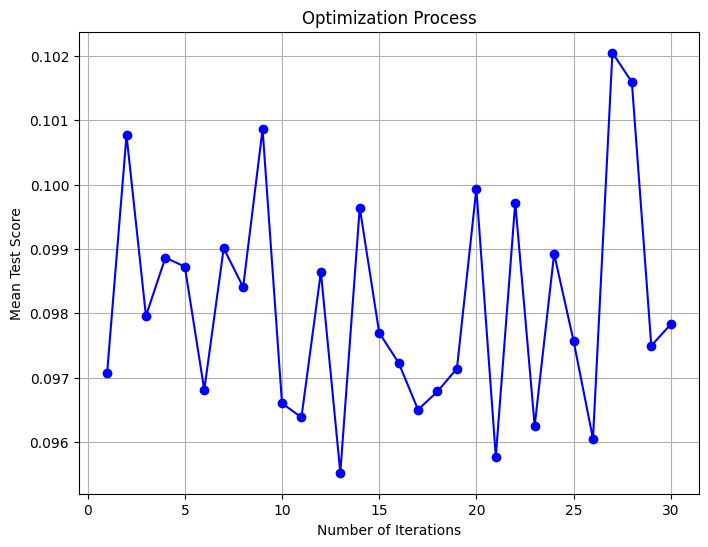

In [16]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'],
         marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

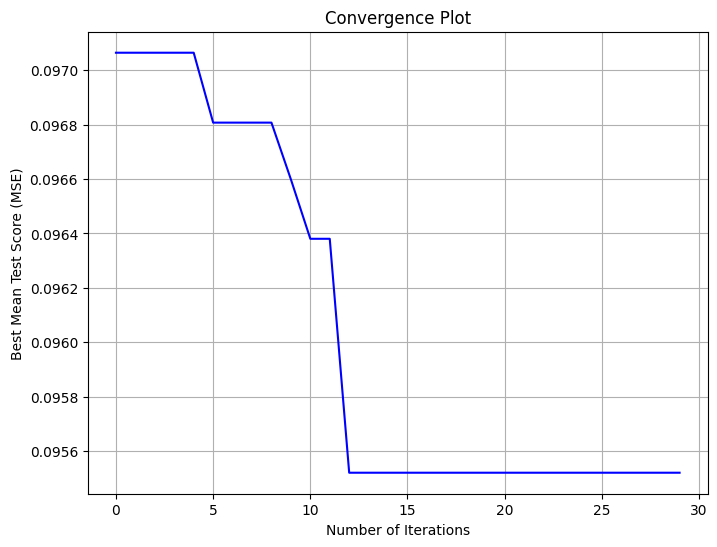

In [17]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

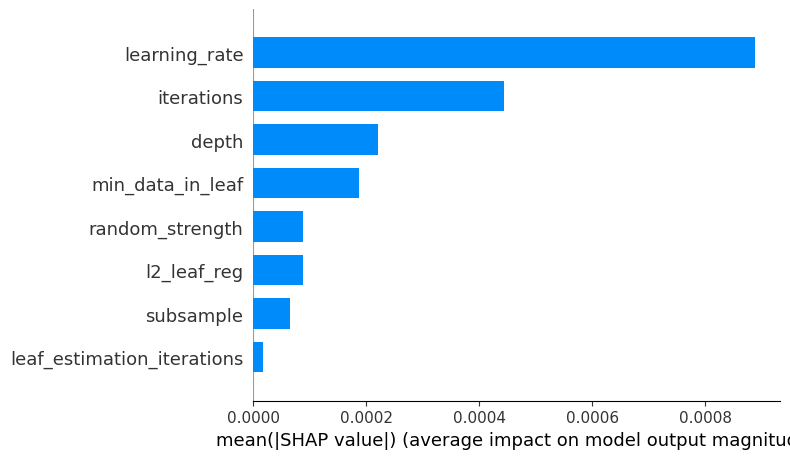

In [18]:

# Mean test scores are negative due to the scoring used
mean_test_scores = -results['mean_test_score']

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# If any hyperparameters are strings (e.g. loss_function), encode them
for col in hyperparams_df.drop('mean_test_score', axis=1).select_dtypes(include='object').columns:
    hyperparams_df[col] = hyperparams_df[col].astype('category').cat.codes

# Rebuild a fresh CatBoostRegressor with the best hyperparameters from search
best_params = opt.best_params_

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = CatBoostRegressor(**best_params, verbose=0)

hyperparam_model.fit(
    hyperparams_df.drop('mean_test_score', axis=1),
    hyperparams_df['mean_test_score']
)

hyperparam_model.fit(hyperparams_df.drop(
    'mean_test_score', axis=1), hyperparams_df['mean_test_score'])


# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop(
    'mean_test_score', axis=1), plot_type="bar")

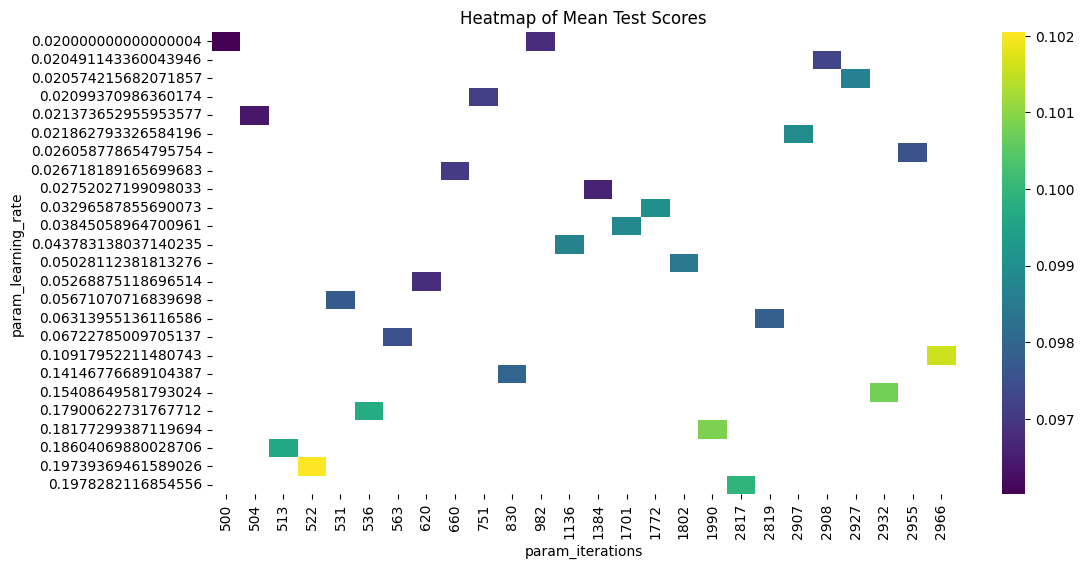

In [19]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [20]:
best_model = joblib.load('sp500_best_catboost_model.pkl')

In [21]:
# Get the train/test indices for the last fold
splits = list(tscv.split(X_train, y_train))
train_idx, test_idx = splits[-1]   # last element

# Slice data
X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
X_te, y_te = X_train.iloc[test_idx], y_train.iloc[test_idx]

best_model.fit(X_tr[selected], y_tr)

# Predictions on the last fold test set
y_pred = model.predict(X_te)

preds_binary = [1 if i > 0 else 0 for i in y_pred]
test_binary = [1 if i > 0 else 0 for i in y_te]

print(confusion_matrix(test_binary, preds_binary))
print(classification_report(test_binary, preds_binary))

[[ 63 145]
 [ 36 252]]
              precision    recall  f1-score   support

           0       0.64      0.30      0.41       208
           1       0.63      0.88      0.74       288

    accuracy                           0.64       496
   macro avg       0.64      0.59      0.57       496
weighted avg       0.64      0.64      0.60       496



In [22]:
# Create a DataFrame to store actual, predicted, and errors
errors = np.abs(y_te - y_pred)
error_df = X_te[['Ticker']].copy()
error_df['Observed'] = y_te
error_df['Predicted'] = y_pred
error_df['Absolute Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(
    by='Absolute Error', ascending=False).head(30)

print('Median absolute error:', np.median(errors))
top_30_errors

Median absolute error: 0.07437823674457743


,Ticker,Observed,Predicted,Absolute Error
3544,COIN,1.035011,0.372697,0.662315
14635,STX,0.674412,0.116094,0.558318
11811,NRG,0.688952,0.133616,0.555337
1381,APH,0.508230,0.069830,0.438400
11991,NVDA,0.563031,0.127211,0.435820
16778,WDC,0.561003,0.136277,0.424726
2919,CEG,0.602941,0.178993,0.423947
13553,RCL,0.528538,0.109413,0.419125
16454,VST,0.652381,0.237818,0.414563
16034,UNH,-0.400125,0.007770,0.407895


In [23]:
# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(
    by='Predicted', ascending=False).head(30)

top_30_errors

,Ticker,Observed,Predicted,Absolute Error
3544,COIN,1.035011,0.372697,0.662315
12295,ON,0.679525,0.319776,0.359750
13013,PLTR,0.615166,0.265645,0.349521
14273,SMCI,0.431367,0.241125,0.190241
16454,VST,0.652381,0.237818,0.414563
1705,AXON,0.574180,0.191927,0.382253
11775,NOW,0.291331,0.182685,0.108645
2919,CEG,0.602941,0.178993,0.423947
4490,DECK,-0.078168,0.176798,0.254966
1165,ANET,0.320470,0.167934,0.152536


In [ ]:
preds = best_model.predict(predict_df[selected])
predict_next = pd.DataFrame([predict_df['Ticker'].unique(), preds*100]).T.rename(
    columns={0: 'Ticker', 1: 'Predicted price change pct'}).sort_values(by='Predicted price change pct',
                                                                        ascending=False)
predict_next.head(30)

,Ticker,Predicted price change pct
372,PLTR,16.665608
158,ENPH,14.223928
430,TECH,12.859405
47,AXON,11.641628
477,WBA,11.445173
25,AMCR,11.262694
8,ADI,10.729454
36,APA,10.637325
109,CRL,10.085594
292,MA,9.907962


In [ ]:
predict_next.tail(15).sort_values(by='Predicted price change pct',
                                  ascending=True)

,Ticker,Predicted price change pct
154,EL,-12.604643
72,CAH,-7.29283
286,LULU,-4.381695
115,CTAS,-3.653231
457,ULTA,-3.418496
119,CVS,-3.283287
437,TMO,-3.280337
147,EA,-3.259444
432,TER,-2.936763
88,CI,-2.832882


In [26]:
# restore normal sleep behavior
ctypes.windll.kernel32.SetThreadExecutionState(0x80000000)

-2147483647